In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
%matplotlib inline

## KDD-99 Dataset

Contains simulation of the US Airforce network. Contains several attacks examples

* 6 weeks
* 7kk records
* 22 types of attacks
* 0 security specialists think it's a good dataset

## Types of Features

* TCP dump info
  * duration
  * protocol type
  * flag
  * etc
  
* Domain knowledge features
  * failed login count
  * su attempted
  * root login
  * etc
 
* Two seconds window statistics
   * server error rate
   * same server errors
   * different server errors
   * etc

## Feature Extraction

In [34]:
from sklearn.datasets import fetch_kddcup99

raw_data = fetch_kddcup99()

kdd_X = pd.DataFrame(raw_data['data'])
kdd_y = pd.Series(raw_data['target'])

column_names = ['duration', 'protocol_type',
                'service', 'flag', 'src_bytes',
                'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins',
                'logged_in', 'num_compromised', 'root_shell',
                'su_attempted', 'num_root', 'num_file_creations',
                'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count',
                'serror_rate', 'srv_serror_rate', 'rerror_rate',
                'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
                'srv_diff_host_rate', 'dst_host_count', 
                'dst_host_srv_count', 'dst_host_same_srv_rate', 
                'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate']

kdd_X.columns = column_names

# Nonumerical columns
object_columns = ['protocol_type', 'service', 'flag']
                


# Transform into numeric type
for column in column_names:
    if column not in object_columns:
        kdd_X[column] = pd.to_numeric(kdd_X[column])

# Dummy encoding
dummies_variables = pd.get_dummies(kdd_X[object_columns])
kdd_X = kdd_X.drop(object_columns, axis=1)
kdd_X = pd.concat([kdd_X, dummies_variables], axis=1)

In [35]:
# Generating train and test set
kdd_y = kdd_y != b'normal.'
normal_elements = kdd_y[~kdd_y].index
normal_train, normal_test = train_test_split(normal_elements, train_size=0.5)
train_x = kdd_X.loc[normal_train]
test_x = kdd_X.drop(normal_train, axis=0)
test_y = kdd_y[test_x.index]

/Users/sklef/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Plotting Functions

In [4]:
def plot_level_lines(model, data, size=100, name=''):
    fig = plt.figure(figsize=(10, 10))
    """Вспомогательная функция для рисование линий уровня и набора точек"""
    x_min = data[:, 0].min() - 0.1
    x_max = data[:, 0].max() + 0.1
    y_min = data[:, 1].min() - 0.1
    y_max = data[:, 1].max() + 0.1
    all_x = np.linspace(x_min, x_max, size)
    all_y = np.linspace(y_min, y_max, size)
    XX, YY = np.meshgrid(all_x, all_y)
    test_data = np.c_[XX.ravel(), YY.ravel()]
    try:
        predictions = model.decision_function(test_data).reshape((size, size))
        data_scores = model.predict(data)
        anomaly_scores = model.decision_function(data)
    except AttributeError:
        predictions = model._decision_function(test_data).reshape((size, size))
        data_scores = model._predict(data)
        anomaly_scores = model._decision_function(data)
        
    plt.contourf(all_x, all_y, predictions)
    plt.colorbar()
    
    threshold = anomaly_scores[data_scores==1.0].min()
    plt.contour(XX, YY, predictions, levels=[threshold], linewidths=5, colors='darkred')

    plt.scatter(data[:, 0], data[:, 1])
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])
    fig.savefig(name)

In [31]:
def plot_results(y_test, probabilities):
    
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    fig, (ax_roc, ax_pr_rec) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    ax_roc.plot(fpr, tpr, linewidth=3)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.grid(True)
    ax_roc.xaxis.label.set_fontsize(20)
    ax_roc.yaxis.label.set_fontsize(20)
    ax_roc.fill_between(fpr, tpr, 0, alpha=0.1)


    ax_pr_rec.plot(recall, precision, linewidth=3)
    ax_pr_rec.set_xlabel('Recall')
    ax_pr_rec.set_ylabel('Precision')
    ax_pr_rec.grid(True)
    ax_pr_rec.xaxis.label.set_fontsize(20)
    ax_pr_rec.yaxis.label.set_fontsize(20)
    ax_pr_rec.fill_between(recall, precision, 0, alpha=0.1)

## Artificial Data Generation

In [5]:
def data_generation(size=100, anomaly_fraction=0.1):
    """Вспомогательная функция для генерации данных"""
    dim_count = 2
    anomaly_size = int(size * anomaly_fraction)
    normal_size = size - anomaly_size
    normal_data = make_blobs(normal_size)[0]
    anomaly_data = np.random.rand(anomaly_size, dim_count)
    x_min = normal_data[:, 0].min()
    x_max = normal_data[:, 0].max()
    y_min = normal_data[:, 1].min()
    y_max = normal_data[:, 1].max()
    anomaly_data[:, 0] *= x_max - x_min
    anomaly_data[:, 1] *= y_max - y_min
    anomaly_data[:, 0] += x_min
    anomaly_data[:, 1] += y_min
    data = np.concatenate([normal_data, anomaly_data], axis=0)
    return data

In [6]:
def unimodal_data_generator(size=100, anomaly_fraction=0.1):
    dim_count = 2
    anomaly_size = int(size * anomaly_fraction)
    normal_size = size - anomaly_size

    linear_transformation = np.array([[2, 0.5],
                                      [0.5, 1.5]])
    normal_data = np.random.randn(normal_size, dim_count) @ linear_transformation
    anomaly_data = np.random.rand(anomaly_size, dim_count)
    x_min = normal_data[:, 0].min()
    x_max = normal_data[:, 0].max()
    y_min = normal_data[:, 1].min()
    y_max = normal_data[:, 1].max()
    anomaly_data[:, 0] *= x_max - x_min
    anomaly_data[:, 1] *= y_max - y_min
    anomaly_data[:, 0] += x_min
    anomaly_data[:, 1] += y_min
    data = np.concatenate([normal_data, anomaly_data], axis=0)
    return data

## Elliptic Enveope

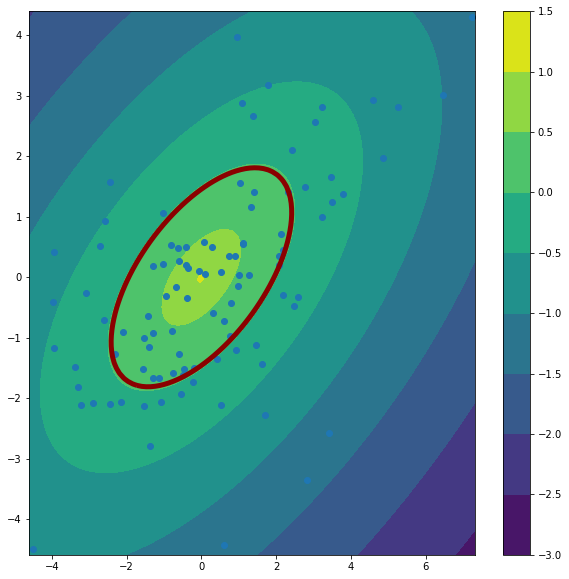

In [10]:
from sklearn.covariance import EllipticEnvelope

data = unimodal_data_generator()

model = EllipticEnvelope(assume_centered=True, # Data centering
                         contamination=0.5) # Anomalies fraction
model.fit(data)
plot_level_lines(model, data, name='elliptic.png')

In [44]:
model = EllipticEnvelope()
model.fit(train_x)
predictions_elliptic = -model.decision_function(test_x)

/Users/sklef/anaconda3/envs/pydata/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


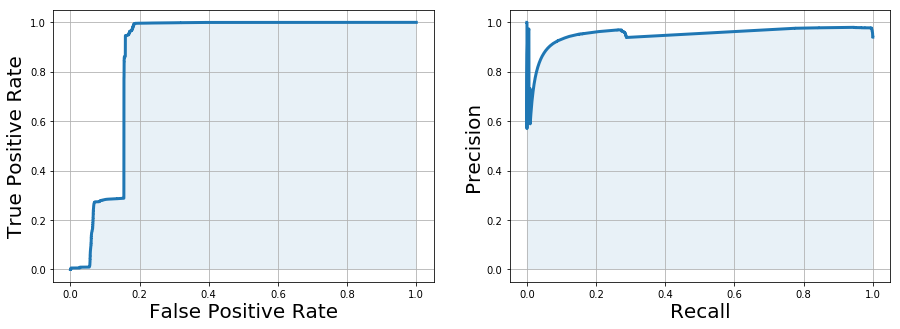

In [45]:
plot_results(test_y, predictions_elliptic)

## Isolation Forest

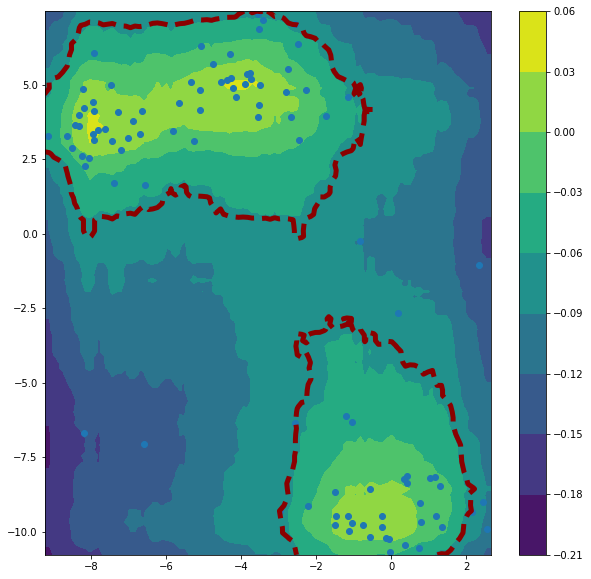

In [12]:
from sklearn.ensemble import IsolationForest

data = data_generation()

model = IsolationForest(n_estimators=100,
                        contamination=0.1,
                        max_features=1.0,
                        max_samples=1.0,
                        bootstrap=True,
                        random_state=0)
model.fit(data)

plot_level_lines(model, data, name='isolation_decision.png')

In [49]:
model = IsolationForest()
model.fit(train_x)
predictions_isolation = -model.decision_function(test_x)

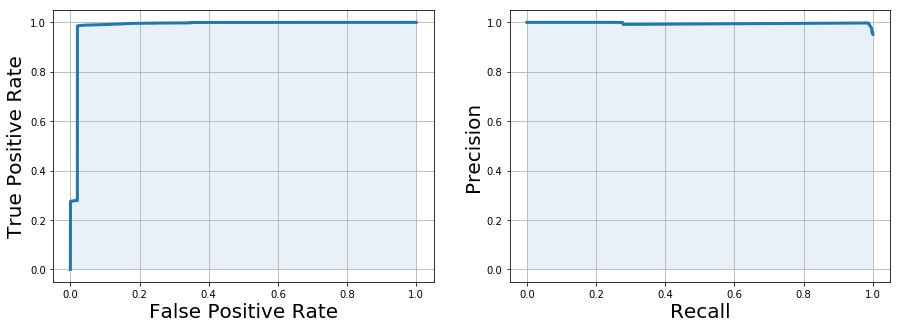

In [50]:
plot_results(test_y, predictions_isolation)

## Local Outlier Factor

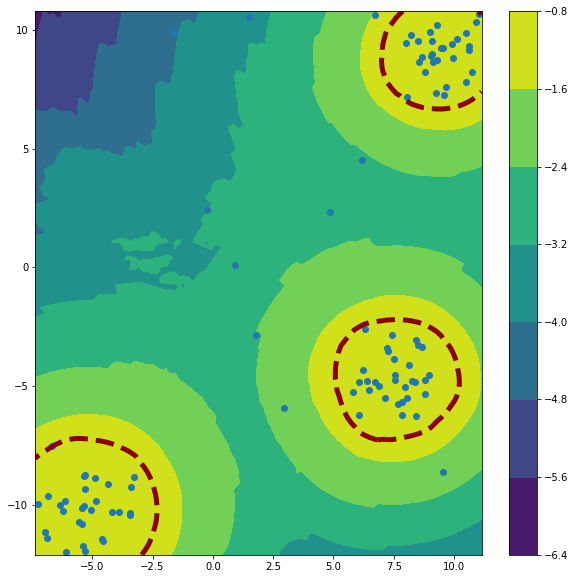

In [13]:
from sklearn.neighbors import LocalOutlierFactor

data = data_generation()

model = LocalOutlierFactor(n_neighbors=20, 
                           contamination=0.1,
                           metric='minkowski', 
                           p=2)
model.fit(data)

plot_level_lines(model, data)

In [53]:
model = LocalOutlierFactor()
model.fit(train_x)
predictions_lof = -model._decision_function(test_x)

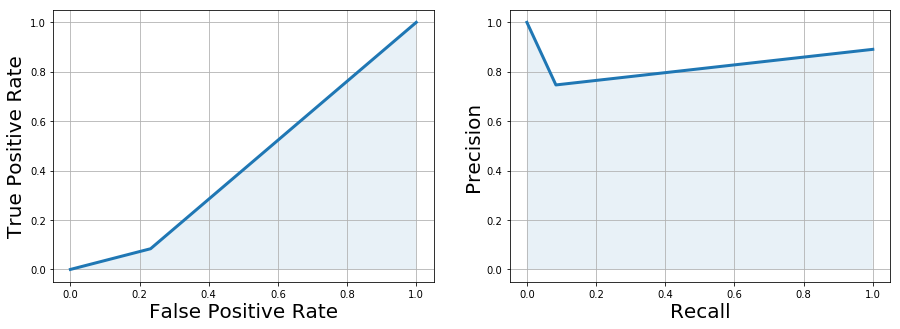

In [54]:
plot_results(test_y, predictions_lof)

## One Class SVM

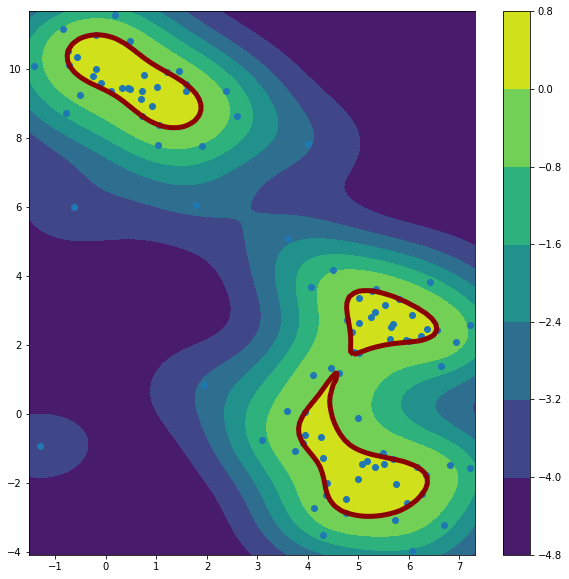

In [14]:
from sklearn.svm import OneClassSVM

data = data_generation()

model = OneClassSVM(nu=0.5, # Anomalies Fraction
                    kernel='rbf', # Kenrel function
                    gamma=0.5) # Kernel width
model.fit(data)

plot_level_lines(model, data, name='oneclass.png')

In [55]:
gamma = 'auto' # could be a number
model = OneClassSVM(nu=0.1, gamma=gamma)
model.fit(train_x)
predictions_svm = -model.decision_function(test_x)

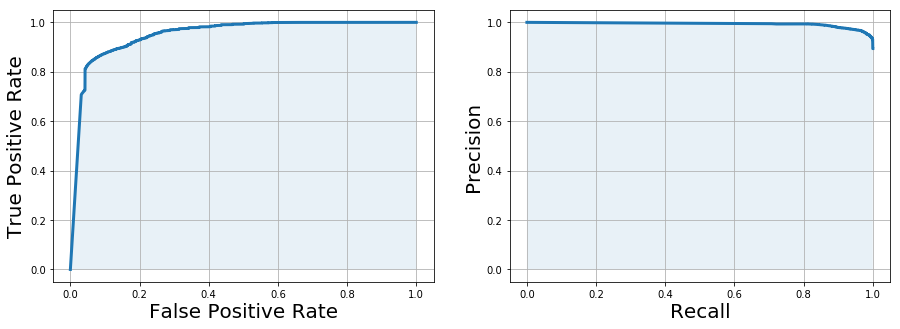

In [57]:
plot_results(test_y, predictions_svm)

## PCA

In [22]:
class PcaAnomalyDetector(BaseEstimator):
    def __init__(self, n_components=2, contamenation=0.1):
        self.pca_model = PCA(n_components=n_components)
        self.contamenation = contamenation
        self.threshold = None
    
    def fit(self, data):
        self.pca_model.fit(data)
        new_data = self.pca_model.transform(data)
        new_data = self.pca_model.inverse_transform(new_data)
        all_distances = np.linalg.norm(data - new_data, axis=1)
        threshold = -np.percentile(all_distances, 100 - self.contamenation*100)
        self.threshold = threshold
        
    def decision_function(self, data):
        new_data = self.pca_model.transform(data)
        new_data = self.pca_model.inverse_transform(new_data)
        scores = np.linalg.norm(data - new_data, axis=1)
        return -scores
    
    def predict(self, data):
        scores = self.decision_function(data)
        return scores > self.threshold
    

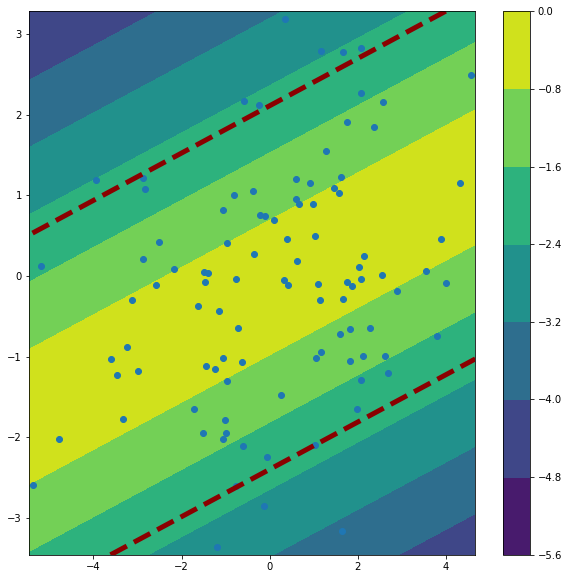

In [23]:
data = unimodal_data_generator()

model = PcaAnomalyDetector(n_components=1)
model.fit(data)
plot_level_lines(model, data, name='pca_level.png')

In [36]:
components_count = 5
model = PcaAnomalyDetector(n_components=components_count)
model.fit(train_x)
predictions = -model.decision_function(test_x)

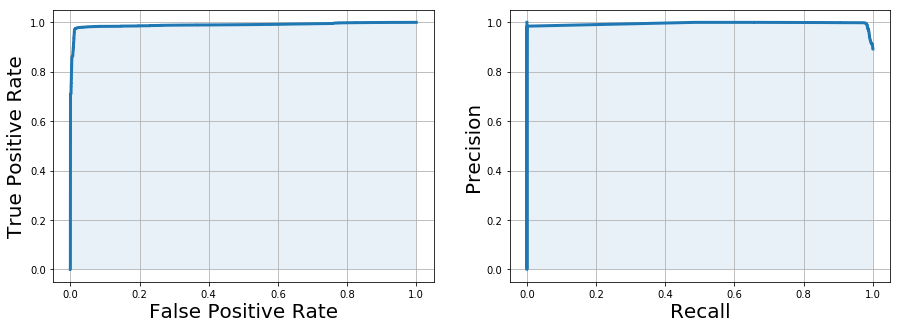

In [40]:
plot_results(test_y, predictions)